In [1]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#data visualization
import matplotlib.pyplot as plt
import glob
import os

In [2]:
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [3]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [4]:
train.shape

(6000000, 2)

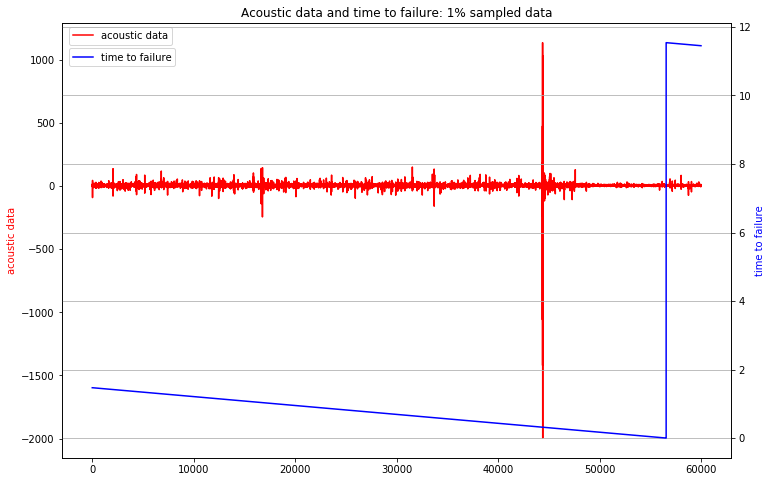

In [5]:
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

# right before vertical blue line(time_to_failure), big spike of red line(signal)

In [6]:
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [7]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [8]:
y_train

0     1.430797
0     1.391499
0     1.353196
0     1.313798
0     1.274400
0     1.236097
0     1.196798
0     1.158496
0     1.119097
0     1.079699
0     1.041396
0     1.001998
0     0.962700
0     0.924397
0     0.884999
0     0.846696
0     0.807297
0     0.767999
0     0.729696
0     0.690298
0     0.650900
0     0.612597
0     0.573299
0     0.534996
0     0.495598
0     0.456199
0     0.417897
0     0.378498
0     0.339200
0     0.300897
       ...    
0    10.862098
0    10.822699
0    10.784397
0    10.744998
0    10.706696
0    10.667397
0    10.627999
0    10.589696
0    10.550298
0    10.511000
0    10.472697
0    10.433298
0    10.394996
0    10.355597
0    10.316299
0    10.277896
0    10.238598
0    10.199200
0    10.160897
0    10.121499
0    10.083196
0    10.043898
0    10.004499
0     9.966196
0     9.926798
0     9.887500
0     9.849197
0     9.809799
0     9.771496
0     9.759796
Length: 4195, dtype: float64

In [9]:
y_train.values[-1]

9.7597955148

In [10]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,4.884113,5.101106,-98.0,104.0,33.662481,-0.024061,-8.0,-2.0,11.0,18.0,104.0,5.576567,4.333325
1,4.725767,6.588824,-154.0,181.0,98.758517,0.390561,-11.0,-2.0,12.0,21.0,181.0,5.734167,5.732777
2,4.906393,6.967397,-106.0,140.0,33.555211,0.217391,-15.0,-3.0,13.0,26.0,140.0,6.152647,5.895945
3,4.902240,6.922305,-199.0,197.0,116.548172,0.757278,-12.0,-2.0,12.0,22.0,199.0,5.933960,6.061214
4,4.908720,7.301110,-126.0,145.0,52.977905,0.064531,-15.0,-2.0,12.0,26.0,145.0,6.110587,6.329485


# Model1: CatBoostRegressor

In [11]:
train_pool = Pool(X_train, y_train)
model = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
model.fit(X_train, y_train, silent=True)

In [12]:
model.best_score_

{'learn': {'MAE': 1.1718835562425074}}

# Model1-1: CatBoostRegressor + GridCV

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = {'depth'         : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'random_seed' : [400, 100, 200],
              'iterations'    : [30, 50, 100]
             }

model = CatBoostRegressor(loss_function='MAE', boosting_type='Ordered')
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs=-1, scoring='neg_mean_absolute_error')

grid.fit(X_train_scaled, y_train.values.flatten())
y_pred_gridCV = grid.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(grid.best_score_))
print(grid.best_params_)

0:	learn: 2.9670833	total: 68.3ms	remaining: 1.98s
1:	learn: 2.9079754	total: 76.2ms	remaining: 1.07s
2:	learn: 2.8028257	total: 84ms	remaining: 756ms
3:	learn: 2.7160661	total: 91.6ms	remaining: 596ms
4:	learn: 2.6219950	total: 98.9ms	remaining: 495ms
5:	learn: 2.5433011	total: 106ms	remaining: 425ms
6:	learn: 2.4770607	total: 114ms	remaining: 373ms
7:	learn: 2.4250035	total: 121ms	remaining: 334ms
8:	learn: 2.3808517	total: 129ms	remaining: 301ms
9:	learn: 2.3347206	total: 137ms	remaining: 273ms
10:	learn: 2.3012161	total: 144ms	remaining: 249ms
11:	learn: 2.2677622	total: 152ms	remaining: 227ms
12:	learn: 2.2396152	total: 159ms	remaining: 208ms
13:	learn: 2.2164215	total: 167ms	remaining: 191ms
14:	learn: 2.1981226	total: 174ms	remaining: 174ms
15:	learn: 2.1804817	total: 182ms	remaining: 159ms
16:	learn: 2.1628309	total: 190ms	remaining: 145ms
17:	learn: 2.1488524	total: 197ms	remaining: 132ms
18:	learn: 2.1372465	total: 205ms	remaining: 119ms
19:	learn: 2.1268836	total: 213ms	rema

In [12]:
y_pred_gridCV[-1]

8.447725550665416

# Model2: SVM(SVR) + kernel for nonlinear decision boundary

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1722
{'C': 2, 'gamma': 0.02}


In [ ]:
y_pred1[-1]

8.39964459365503

# Model1 test data

In [104]:
path = r'/Users/parkchanjin/PycharmProjects/ml-work/EarthquakeKaggle/test' # use your path
all_files = glob.glob(path + "/*.csv")

new_index = ['id', 't']
df = pd.DataFrame()
_df = pd.DataFrame()

for filename in all_files:
    test = pd.read_csv(filename, dtype={'acoustic_data': np.int16})
    X_test = pd.DataFrame()
    
    ch = gen_features(test['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)
    prediction = model.predict(X_test)
    
    _df['time_to_failure'] = prediction
    name = os.path.basename(filename)
    _df['seg_id'] = os.path.splitext(name)[0]
    df = df.append(_df)
    
df = df.reindex(new_index, axis="columns")


In [105]:
df.reset_index(drop=True, inplace=True)   
df.head()

,seg_id,time_to_failure
0,seg_51f0a2,3.964025
1,seg_de98fa,3.632301
2,seg_ad82ca,5.236562
3,seg_e3ca24,8.101407
4,seg_64f8dc,4.379363


In [106]:
df.to_csv('submission1.csv', index=False)
submission1 = pd.read_csv('submission1.csv')
submission1.head()

,seg_id,time_to_failure
0,seg_51f0a2,3.964025
1,seg_de98fa,3.632301
2,seg_ad82ca,5.236562
3,seg_e3ca24,8.101407
4,seg_64f8dc,4.379363


In [17]:
!kaggle competitions submit -c LANL-Earthquake-Prediction -f submission1.csv -m "first"

100%|██████████████████████████████████████| 74.8k/74.8k [00:06<00:00, 12.7kB/s]
Successfully submitted to LANL Earthquake Prediction

# Model1-1 test data

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = {'depth'         : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'random_seed' : [400, 100, 200],
              'iterations'    : [30, 50, 100]
             }

model = CatBoostRegressor(loss_function='MAE', boosting_type='Ordered')
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs=-1, scoring='neg_mean_absolute_error')

grid.fit(X_train_scaled, y_train.values.flatten())
y_pred_gridCV = grid.predict(X_train_scaled)

In [13]:
path = r'/Users/parkchanjin/PycharmProjects/ml-work/EarthquakeKaggle/test' # use your path
all_files = glob.glob(path + "/*.csv")

new_index = ['seg_id', 'time_to_failure']
df = pd.DataFrame()
_df = pd.DataFrame()

scaler = StandardScaler()
scaler.fit(X_train)

model = CatBoostRegressor(loss_function='MAE', boosting_type='Ordered')
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid.fit(X_train_scaled, y_train.values.flatten())

for filename in all_files:
    test = pd.read_csv(filename, dtype={'acoustic_data': np.int16})
    X_test = pd.DataFrame()
    
    ch = gen_features(test['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)
    
    X_test_scaled = scaler.transform(X_test)
    prediction = grid.predict(X_test_scaled)
    
    _df['time_to_failure'] = prediction
    name = os.path.basename(filename)
    _df['seg_id'] = os.path.splitext(name)[0]
    df = df.append(_df)
    
df = df.reindex(new_index, axis="columns")
df.reset_index(drop=True, inplace=True) 

0:	learn: 2.9670833	total: 13.3ms	remaining: 386ms
1:	learn: 2.9079754	total: 22.6ms	remaining: 316ms
2:	learn: 2.8028257	total: 32.1ms	remaining: 289ms
3:	learn: 2.7160661	total: 39.7ms	remaining: 258ms
4:	learn: 2.6219950	total: 47ms	remaining: 235ms
5:	learn: 2.5433011	total: 54.2ms	remaining: 217ms
6:	learn: 2.4770607	total: 61.6ms	remaining: 203ms
7:	learn: 2.4250035	total: 69.5ms	remaining: 191ms
8:	learn: 2.3808517	total: 76.8ms	remaining: 179ms
9:	learn: 2.3347206	total: 84.6ms	remaining: 169ms
10:	learn: 2.3012161	total: 92.3ms	remaining: 159ms
11:	learn: 2.2677622	total: 99.7ms	remaining: 150ms
12:	learn: 2.2396152	total: 107ms	remaining: 141ms
13:	learn: 2.2164215	total: 115ms	remaining: 132ms
14:	learn: 2.1981226	total: 123ms	remaining: 123ms
15:	learn: 2.1804817	total: 131ms	remaining: 114ms
16:	learn: 2.1628309	total: 138ms	remaining: 106ms
17:	learn: 2.1488524	total: 146ms	remaining: 97.2ms
18:	learn: 2.1372465	total: 154ms	remaining: 89ms
19:	learn: 2.1268836	total: 164

In [14]:
df.to_csv('submissionGrid3.csv', index=False)
submission2 = pd.read_csv('submissionGrid3.csv')
submission2.head()

,seg_id,time_to_failure
0,seg_51f0a2,4.005873
1,seg_de98fa,2.948909
2,seg_ad82ca,6.564157
3,seg_e3ca24,6.550343
4,seg_64f8dc,5.098179


# Model2 test data

In [26]:
path = r'/Users/parkchanjin/PycharmProjects/ml-work/EarthquakeKaggle/test' # use your path
all_files = glob.glob(path + "/*.csv")

new_index = ['seg_id', 'time_to_failure']
df = pd.DataFrame()
_df = pd.DataFrame()

scaler = StandardScaler()
scaler.fit(X_train)

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())

for filename in all_files:
    test = pd.read_csv(filename, dtype={'acoustic_data': np.int16})
    X_test = pd.DataFrame()
    
    ch = gen_features(test['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)
    
    X_test_scaled = scaler.transform(X_test)
    
    prediction = reg1.predict(X_test_scaled)
    
    _df['time_to_failure'] = prediction
    name = os.path.basename(filename)
    _df['seg_id'] = os.path.splitext(name)[0]
    df = df.append(_df)
    
df = df.reindex(new_index, axis="columns")
df.reset_index(drop=True, inplace=True) 

In [23]:
df.to_csv('submission2.csv', index=False)
submission2 = pd.read_csv('submission2.csv')
submission2.head()

,seg_id,time_to_failure
0,seg_51f0a2,4.196444
1,seg_de98fa,3.069718
2,seg_ad82ca,6.245538
3,seg_e3ca24,6.182282
4,seg_64f8dc,5.041366


In [25]:
!kaggle competitions submit -c LANL-Earthquake-Prediction -f submission2.csv -m "second"

100%|██████████████████████████████████████| 74.7k/74.7k [00:07<00:00, 10.8kB/s]
Successfully submitted to LANL Earthquake Prediction